> # Neural Network Basic - Week3 과제


## Import Library

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist

## Load Dataset
- MNIST 

In [2]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [3]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [6]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        return 1/(1+np.exp(-x))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        return x*(1-x)

In [8]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        return np.maximun(0,x)
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        return np.where(x>0,1,0) #0보다 큰 값은 1의 그레디언트

In [9]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [10]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [11]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [12]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr #러닝레이트
        self.epoch = epoch  #에폭
        self.batch_size = batch_size #배치사이즈
        self.loss_function = cross_entropy #크로스엔트로피
        self.layers = [] #layer를 담고있는 배열
        self.activations = [softmax] #활성화함수는 스프트맥스
        self.nodes = [] #레이어 노드 수에 대한 리스트
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): #레이어를 추가할 때 호출한다
        self.layers.append(Layer) #레이어를 하나 붙여주기
        if not self.nodes: #nodes가 비어있으면
            self.nodes.append(np.zeros(Layer.input_size)) #노드를 새로 붙여준다(0으로 초기화된)
        self.nodes.append(np.zeros(Layer.output_size))
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation): #활성화함수를 더해준다.
        tmp = self.activations.pop() #마지막으로 쓰였던 활성화함수를 뽑나내구
        self.activations.append(Activation)  # 새로운 활성화함수 추가
        self.activations.append(tmp) #tmp를 뒤에 다시 붙여주기
        
    # 순전파 함수
    def _forward(self, X): #순전파
        self.nodes[0] = X.copy() #입력받은 X로 첫번째노드를 초기화해라
        output = X.copy() #OUTPUT도 X로 초기화하기
        for i in range(len(self.layers)): #레이어 수만큼 포문 돌기
            Layer = self.layers[i] 
            Activation = self.activations[i] #레이어별 활성화 함수 지정하기
            output = np.dot(self.nodes[i], Layer.weight) #노드와 레이어의 가중치 곱하기
            output = output+ Layer.bias #OUPUT에 BIAS 더하기
            output = Activation.forward(output) #활성화함수 적용하기
            self.nodes[i+1] = output #그 다음 노드값은 현재 OUPUT으로 초기화
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): #레이어 길이의 반대 순으로 실행하기
            a = self.nodes[i+1] # 그 다음 레이어의 값을 a로 지정
            Layer = self.layers[i] # 현재 레이어값
            Activation = self.activations[i] #활성화함수
            
            if i+1 == len(self.layers): #현재 레이어가 가장 마지막 레이어라면
                error = Activation.backward(output, y) # 가장마지막output의 미분값이 error
            else:
                error *= Activation.backward(a) # 현재 레이어가 가장 마지막 레이어가 아니면 error 곱해주기
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0]#가중치업데이트 
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0] #bias 업데이트
            error = np.dot(error, Layer.weight.T) #에러 계산
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1) #소프트맥스 확률중 가장 높은 값 반환
        return np.sum(pre_p==y)/y.shape[0]  #분류가 잘된 비율
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch):
            for j in range(N//self.batch_size):  #minibatch 크기만큼
                batch_mask = np.random.choice(N, self.batch_size)#배치사이즈만큼 랜덤 뽑기
                X_batch = X[batch_mask] #배치 추출
                y_batch = y[batch_mask] #배치 추출
                output = self._forward(X_batch) #배치 순전파
                self._backward(X_batch, output, y_batch) #배치 역전파
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) 
            history["val_acc"].append(self._accuracy(output, val_y)) 
            history["val_loss"].append(sum(self.loss_function(output, val_y))) 
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [16]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=20, batch_size=32)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [17]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [18]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1149
0 test loss     : 22913.830877491142
10 test accuracy : 0.7894
10 test loss     : 7979.801884941303


## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

c:\Users\momo8\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\momo8\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\momo8\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


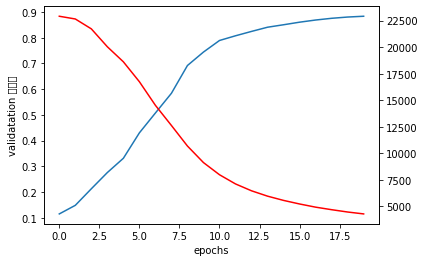

In [23]:
fig = plt.figure()
a = fig.add_subplot(111)

a.plot(range(20),history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('validatation 정확도')
b=a.twinx() #위에다 그리기(x-axis를 공유하지만 y-axis는 공유하지 않는 fig)
b.plot(history['val_loss'],color='red')
plt.show()

In [19]:
range(10)

range(0, 10)